<a href="https://colab.research.google.com/github/wujj0326/COVID_Risk_Competition/blob/master/COVID_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import packages

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

## import data

### Daily Confirmed Cases in each place of Los Angeles County

In [0]:
all_comp = pd.read_csv('https://data.chhs.ca.gov/dataset/6882c390-b2d7-4b9a-aefa-2068cee63e47/resource/6cd8d424-dfaa-4bdd-9410-a3d656e1176e/download/covid19data.csv')

In [55]:
la_comp = all_comp[all_comp['County Name']=='Los Angeles'].reset_index().drop('index',axis=1)
la_comp['Date_new3'] = pd.to_datetime(la_comp['Most Recent Date']).dt.strftime('%-m/%-d/%Y')
la_comp['new_confirmed'] = la_comp['Total Count Confirmed'].diff()
la_comp['new_death'] = la_comp['Total Count Deaths'].diff()
la_comp.fillna(0,inplace=True)
la_comp

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,Date_new3,new_confirmed,new_death
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0,4/1/2020,0.0,0.0
1,Los Angeles,4/2/2020,4040.0,79.0,818.0,1270.0,346.0,193.0,4/2/2020,538.0,13.0
2,Los Angeles,4/3/2020,4566.0,91.0,962.0,1239.0,422.0,209.0,4/3/2020,526.0,12.0
3,Los Angeles,4/4/2020,5275.0,117.0,1007.0,1190.0,449.0,181.0,4/4/2020,709.0,26.0
4,Los Angeles,4/5/2020,5892.0,130.0,1094.0,1082.0,473.0,166.0,4/5/2020,617.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...
63,Los Angeles,06/03/2020,58166.0,2489.0,1488.0,502.0,435.0,78.0,6/3/2020,1022.0,46.0
64,Los Angeles,06/04/2020,59596.0,2531.0,1462.0,586.0,453.0,99.0,6/4/2020,1430.0,42.0
65,Los Angeles,06/05/2020,60955.0,2565.0,1451.0,547.0,439.0,109.0,6/5/2020,1359.0,34.0
66,Los Angeles,06/06/2020,62269.0,2620.0,1399.0,582.0,418.0,88.0,6/6/2020,1314.0,55.0


### Hospital Time Series Data in LA County

In [56]:
# LA Hospital beds time series data
LA_HOS_ITEM_ID = "3da1eb3e13a14743973c96b945bd1117"

LA_HOS_URL = f"http://lahub.maps.arcgis.com/sharing/rest/content/items/{LA_HOS_ITEM_ID}/data"

la_hos = pd.read_csv(LA_HOS_URL)
la_hos

,Date,Type,Status,Count,Source
0,4/3/2020,Acute Care Beds,Available,1378.0,NaN
1,4/3/2020,Acute Care Beds,COVID Occupied,1152.0,NaN
2,4/3/2020,Acute Care Beds,Licensed Unreported Beds,631.0,NaN
3,4/3/2020,Acute Care Beds,Unavailable,13839.0,NaN
4,4/3/2020,ICU Beds,Available,239.0,NaN
...,...,...,...,...,...
721,6/7/2020,ICU Beds,Unavailable,NaN,NaN
722,6/7/2020,Ventilators,Available,1138.0,NaN
723,6/7/2020,Ventilators,COVID Person Under Investigation,45.0,NaN
724,6/7/2020,Ventilators,COVID Occupied,242.0,NaN


In [57]:
la_hos_icu = la_hos[la_hos['Type']=='ICU Beds'][la_hos['Status']=='Available'].drop('Source',axis=1)
la_hos_icu.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Date,Type,Status,Count
670,6/3/2020,ICU Beds,Available,143.0
682,6/4/2020,ICU Beds,Available,160.0
694,6/5/2020,ICU Beds,Available,176.0
706,6/6/2020,ICU Beds,Available,170.0
718,6/7/2020,ICU Beds,Available,130.0


### Test Performed Time Series Data in both LA County and City

In [58]:
# LA Test Performed time series data
LA_TEST_ITEM_ID = "3cfd003985b447c994a7252e8eb97b92"

LA_TEST_URL = f"http://lahub.maps.arcgis.com/sharing/rest/content/items/{LA_TEST_ITEM_ID}/data"

la_test = pd.read_csv(LA_TEST_URL)
la_test

,Date,Performed,Cumulative,City_Performed,City_Cumulative
0,2020-03-20,145,145,145,145
1,2020-03-21,100,245,100,245
2,2020-03-22,0,245,0,245
3,2020-03-23,694,939,694,939
4,2020-03-24,1072,2011,1072,2011
...,...,...,...,...,...
75,2020-06-03,9677,555667,2774,317706
76,2020-06-04,10751,566418,2874,320580
77,2020-06-05,14625,581043,6814,327394
78,2020-06-06,14243,595286,6754,334148


In [0]:
la_test['Date_new'] = pd.to_datetime(la_test['Date']).dt.strftime('%-m/%-d/%Y')

### Google Mobility Data in LA county


In [60]:
glob_mob = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=b8b0c30cbee5f341',low_memory=False)
la_mob = glob_mob[glob_mob['sub_region_2']=='Los Angeles County'].reset_index().drop('index',axis=1)
la_mob['Date_new2'] = pd.to_datetime(la_mob['date']).dt.strftime('%-m/%-d/%Y')
la_mob

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date_new2
0,US,United States,California,Los Angeles County,2020-02-15,1.0,0.0,13.0,-1.0,-1.0,0.0,2/15/2020
1,US,United States,California,Los Angeles County,2020-02-16,4.0,-1.0,27.0,-1.0,0.0,-1.0,2/16/2020
2,US,United States,California,Los Angeles County,2020-02-17,7.0,0.0,30.0,-11.0,-32.0,7.0,2/17/2020
3,US,United States,California,Los Angeles County,2020-02-18,-1.0,0.0,11.0,2.0,2.0,0.0,2/18/2020
4,US,United States,California,Los Angeles County,2020-02-19,-1.0,-1.0,13.0,1.0,2.0,0.0,2/19/2020
...,...,...,...,...,...,...,...,...,...,...,...,...
100,US,United States,California,Los Angeles County,2020-05-25,-46.0,-13.0,16.0,-52.0,-72.0,24.0,5/25/2020
101,US,United States,California,Los Angeles County,2020-05-26,-43.0,-13.0,-12.0,-43.0,-42.0,18.0,5/26/2020
102,US,United States,California,Los Angeles County,2020-05-27,-42.0,-13.0,-8.0,-42.0,-42.0,18.0,5/27/2020
103,US,United States,California,Los Angeles County,2020-05-28,-41.0,-12.0,-10.0,-43.0,-42.0,19.0,5/28/2020


## Merge Data

In [61]:
merge1 = pd.merge(la_hos_icu, la_test, how='inner', left_on='Date', right_on='Date_new')
merge2 = pd.merge(la_comp, merge1, how = 'inner', left_on='Date_new3', right_on='Date_new')
merge3 = pd.merge(la_mob, merge2, how = 'inner', left_on='Date_new2', right_on='Date_new')
merge3.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date_new2,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,Date_new3,new_confirmed,new_death,Date_x,Type,Status,Count,Date_y,Performed,Cumulative,City_Performed,City_Cumulative,Date_new
0,US,United States,California,Los Angeles County,2020-04-03,-43.0,-15.0,-38.0,-51.0,-51.0,25.0,4/3/2020,Los Angeles,4/3/2020,4566.0,91.0,962.0,1239.0,422.0,209.0,4/3/2020,526.0,12.0,4/3/2020,ICU Beds,Available,239.0,2020-04-03,2621,16667,2005,15632,4/3/2020
1,US,United States,California,Los Angeles County,2020-04-04,-50.0,-20.0,-54.0,-51.0,-41.0,20.0,4/4/2020,Los Angeles,4/4/2020,5275.0,117.0,1007.0,1190.0,449.0,181.0,4/4/2020,709.0,26.0,4/4/2020,ICU Beds,Available,246.0,2020-04-04,2478,19145,1916,17548,4/4/2020
2,US,United States,California,Los Angeles County,2020-04-05,-53.0,-27.0,-59.0,-57.0,-43.0,17.0,4/5/2020,Los Angeles,4/5/2020,5892.0,130.0,1094.0,1082.0,473.0,166.0,4/5/2020,617.0,13.0,4/5/2020,ICU Beds,Available,318.0,2020-04-05,2277,21422,1714,19262,4/5/2020
3,US,United States,California,Los Angeles County,2020-04-06,-49.0,-27.0,-58.0,-59.0,-54.0,25.0,4/6/2020,Los Angeles,4/6/2020,6346.0,145.0,1166.0,1070.0,486.0,175.0,4/6/2020,454.0,15.0,4/6/2020,ICU Beds,Available,258.0,2020-04-06,375,21797,4,19266,4/6/2020
4,US,United States,California,Los Angeles County,2020-04-07,-51.0,-30.0,-58.0,-58.0,-54.0,26.0,4/7/2020,Los Angeles,4/7/2020,6885.0,170.0,1251.0,1350.0,517.0,162.0,4/7/2020,539.0,25.0,4/7/2020,ICU Beds,Available,247.0,2020-04-07,2979,24776,2208,21474,4/7/2020


In [62]:
final = merge3.iloc[:,np.r_[-1,5:10,14:19,24,26]].rename(columns = {'Count':'ICU_available_count'})
final.head()

,Date_new,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,Type,ICU_available_count
0,4/3/2020,-43.0,-15.0,-38.0,-51.0,-51.0,4566.0,91.0,962.0,1239.0,422.0,ICU Beds,239.0
1,4/4/2020,-50.0,-20.0,-54.0,-51.0,-41.0,5275.0,117.0,1007.0,1190.0,449.0,ICU Beds,246.0
2,4/5/2020,-53.0,-27.0,-59.0,-57.0,-43.0,5892.0,130.0,1094.0,1082.0,473.0,ICU Beds,318.0
3,4/6/2020,-49.0,-27.0,-58.0,-59.0,-54.0,6346.0,145.0,1166.0,1070.0,486.0,ICU Beds,258.0
4,4/7/2020,-51.0,-30.0,-58.0,-58.0,-54.0,6885.0,170.0,1251.0,1350.0,517.0,ICU Beds,247.0


In [63]:
final.shape

(57, 13)

In [64]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 13 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Date_new                                            57 non-null     object 
 1   retail_and_recreation_percent_change_from_baseline  57 non-null     float64
 2   grocery_and_pharmacy_percent_change_from_baseline   57 non-null     float64
 3   parks_percent_change_from_baseline                  57 non-null     float64
 4   transit_stations_percent_change_from_baseline       57 non-null     float64
 5   workplaces_percent_change_from_baseline             57 non-null     float64
 6   Total Count Confirmed                               57 non-null     float64
 7   Total Count Deaths                                  57 non-null     float64
 8   COVID-19 Positive Patients                          57 non-null     float64
 9   S

In [0]:
# final.to_csv('final_data.csv',index=False)

## Preprocessing


In [0]:
# reference:https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


two variables (ICU availability and total confirmed cases)

In [0]:
test = merge2.iloc[:,np.r_[2,14,20]]
test.set_index('Date_new',inplace=True)

testv = test.values
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled_t = scaler2.fit_transform(testv)

testd = series_to_supervised(scaled_t)


X_train = testd.iloc[:40,:2].values
X_test = testd.iloc[40:,:2].values
y_train = testd.iloc[:40,2].values
y_test = testd.iloc[40:,2].values

In [0]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Model Building

Epoch 1/50
8/8 - 0s - loss: 0.1991 - val_loss: 0.6928
Epoch 2/50
8/8 - 0s - loss: 0.1683 - val_loss: 0.6549
Epoch 3/50
8/8 - 0s - loss: 0.1528 - val_loss: 0.6222
Epoch 4/50
8/8 - 0s - loss: 0.1442 - val_loss: 0.5954
Epoch 5/50
8/8 - 0s - loss: 0.1402 - val_loss: 0.5729
Epoch 6/50
8/8 - 0s - loss: 0.1361 - val_loss: 0.5520
Epoch 7/50
8/8 - 0s - loss: 0.1319 - val_loss: 0.5315
Epoch 8/50
8/8 - 0s - loss: 0.1281 - val_loss: 0.5118
Epoch 9/50
8/8 - 0s - loss: 0.1245 - val_loss: 0.4925
Epoch 10/50
8/8 - 0s - loss: 0.1213 - val_loss: 0.4741
Epoch 11/50
8/8 - 0s - loss: 0.1187 - val_loss: 0.4576
Epoch 12/50
8/8 - 0s - loss: 0.1166 - val_loss: 0.4436
Epoch 13/50
8/8 - 0s - loss: 0.1144 - val_loss: 0.4309
Epoch 14/50
8/8 - 0s - loss: 0.1119 - val_loss: 0.4187
Epoch 15/50
8/8 - 0s - loss: 0.1092 - val_loss: 0.4063
Epoch 16/50
8/8 - 0s - loss: 0.1064 - val_loss: 0.3937
Epoch 17/50
8/8 - 0s - loss: 0.1035 - val_loss: 0.3806
Epoch 18/50
8/8 - 0s - loss: 0.1005 - val_loss: 0.3671
Epoch 19/50
8/8 - 0

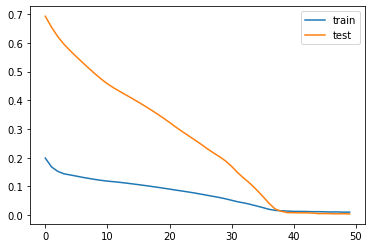

In [69]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [70]:
# make a prediction
yhat = model.predict(X_test)
X_test_re = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test_re[:, 1:]), axis=1)
inv_yhat = scaler2.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test_re = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test_re, X_test_re[:, 1:]), axis=1)
inv_y = scaler2.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 334.774


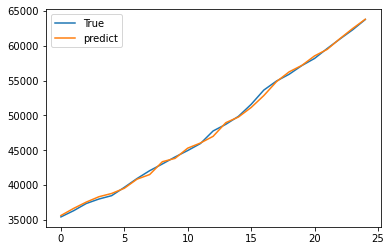

In [71]:
plt.plot(inv_y, label='True')
plt.plot(inv_yhat, label='predict')
plt.legend()

## Get Risk Score

In [0]:
risk = pd.read_csv('https://raw.githubusercontent.com/wujj0326/COVID_Risk_Competition/master/risk_confirmed.csv')

In [73]:
risk.head()

,City,confirmed_cases,death_cases,pop2010,avg_traffic,avg_asthma,avg_cardiovascular,avg_poverty,avg_elderly,pop_dens
0,Acton,11,1,53654,1058.69,73.62,11.00,70.81,5.24,120974.0
1,Agoura Hills,35,1,60009,1023.45,77.60,10.95,72.49,5.45,177875.5
2,Alhambra,226,8,112060,1816.86,47.43,7.17,46.00,10.40,551582.0
3,Altadena,157,5,69531,1379.59,34.64,5.34,55.34,10.67,864902.9
4,Arcadia,104,7,70416,1305.56,49.61,6.12,73.43,8.78,755363.9


In [0]:
# normalize the scale by using minmaxscaler
scale_risk = MinMaxScaler(feature_range=(0, 1))
features = scale_risk.fit_transform(risk.iloc[:,3:-1])

#  vulnerable factors related to death cases

# •       elderly

# •       asthma

# •       cardiovascular

#  vulnearble factors related to infected cases

# •       poverty: the higher the value the poorer the area

# •       traffic

# •       population

confirm_feat = np.sum(features[:,np.r_[0,1,4]],axis=1)
death_feat = np.sum(features[:,np.r_[2,3,5]],axis=1)

In [0]:
# apply sigmoid function to confirm feature and death feature
sig_confirmed = 1/(1 + np.exp(confirm_feat)) 
sig_death = 1/(1 + np.exp(death_feat)) 

In [0]:
risk['confirmed_score'] = sig_confirmed
risk['death_score'] = sig_death

In [0]:
risk_score = risk.iloc[:,np.r_[0,1,-2,2,-1]]

In [0]:
# replace 0 to 1, so that it would not be 0 after multiplying by their corresponding score
risk_score['confirmed_cases'] = risk_score['confirmed_cases'].replace(0,1)
risk_score['death_cases'] = risk_score['death_cases'].replace(0,1)

In [82]:
# multiply the score
risk_score['risk_confirmed_score'] = risk_score['confirmed_cases']*risk_score['confirmed_score']
risk_score['risk_death_score'] = risk_score['death_cases']*risk_score['death_score']

,City,confirmed_cases,confirmed_score,death_cases,death_score,risk_confirmed_score,risk_death_score
0,Acton,11,0.189272,1,0.220192,2.081997,0.220192
1,Agoura Hills,35,0.181774,1,0.213950,6.362097,0.213950
2,Alhambra,226,0.144250,8,0.270825,32.600493,2.166598
3,Altadena,157,0.187301,5,0.329177,29.406182,1.645884
4,Arcadia,104,0.155135,7,0.314134,16.133990,2.198941
...,...,...,...,...,...,...,...
85,Venice,69,0.341497,2,0.290481,23.563303,0.580962
86,West Hills,151,0.418424,15,0.205003,63.181958,3.075038
87,Wilmington,301,0.234219,3,0.206903,70.500003,0.620710
88,Winnetka,325,0.254805,4,0.189505,82.811556,0.758021


In [0]:
# Scores for each city in LA county
risk_score_final =  risk_score.iloc[:,[0,-1,-2]]

In [0]:
# risk_score.to_csv('risk_score.csv',index=False)
risk_score_final.to_csv('risk_score_final.csv',index=False)